In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TICKER = "SPY"
WINDOW = 20
LOOKBACK = 100000
INTERVAL = "1h"
if INTERVAL == "1h":
  PERIOD = '730d'
else:
  PERIOD = "max"
  

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30


/var/folders/ln/kls56lq93mq4z_459sxk1vbh0000gn/T/ipykernel_14472/2856225333.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=period)
[*********************100%***********************]  1 of 1 completed


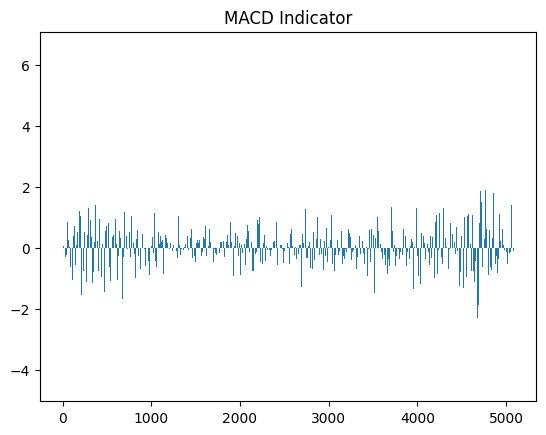

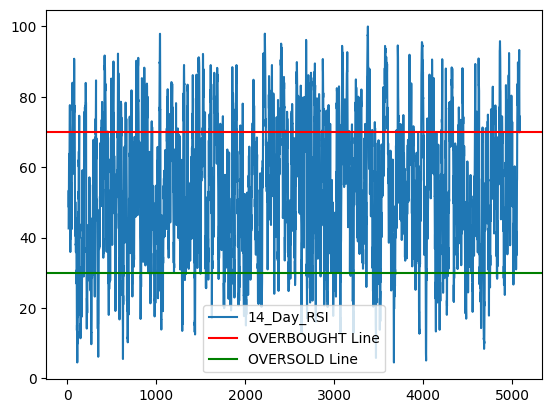

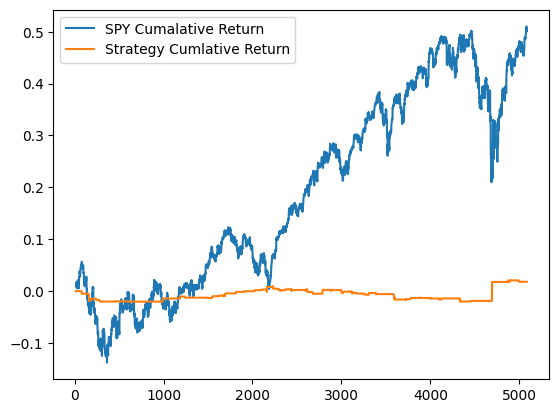

In [26]:
def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL, period=PERIOD):
    df = yf.download(ticker, interval=interval, period=period)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]


def add_macd(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f"{fast}_ema"] = df["Close"].ewm(span=fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span=slow).mean()

    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    df["Signal"] = df["MACD"].ewm(span=span).mean()

    df["MACD_hist"] = df["MACD"] - df["Signal"]

    plt.bar(x=range(len(df)), height=df["MACD_hist"])
    plt.title("MACD Indicator")
    return df


def add_macd_strategy(df):
    df["MACD_Strategy"] = np.where(df["MACD_hist"] > 0, 1, -1)
    return df


def add_rsi(df):

    price_change = df["Close"].diff()

    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    avg_gain = gain.rolling(RSI_LENGTH).mean()
    avg_loss = loss.rolling(RSI_LENGTH).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f"{RSI_LENGTH}_Day_RSI"] = rsi

    plt.figure()
    plt.plot(df[f"{RSI_LENGTH}_Day_RSI"])
    plt.axhline(OVERBOUGHT, color="red")
    plt.axhline(OVERSOLD, color="green")
    plt.legend([f"{RSI_LENGTH}_Day_RSI", "OVERBOUGHT Line", "OVERSOLD Line"])

    return df.dropna()


def add_rsi_strategy(df):
    df["RSI_Strategy"] = 0
    df["RSI_Strategy"] = np.where(
        df[f"{RSI_LENGTH}_Day_RSI"] > OVERBOUGHT,
        -1,
        np.where(df[f"{RSI_LENGTH}_Day_RSI"] < OVERSOLD, 1, 0),
    )
    return df


def add_full_strategy(df):
    df["Full_Strategy"] = df["RSI_Strategy"] + df["MACD_Strategy"]
    df["Strategy"] = np.where(
        df["Full_Strategy"] == 2,
        1,
        np.where(
            df["Full_Strategy"] == -2,
            -1,0
        )
    )
    df["Strategy"] = df["Strategy"].shift(1)
    return df


def test_strategy(df):
    df["Cumalative Return"] = np.cumprod(1 + df["Close"].pct_change()) - 1
    df["RSI Cumalative Return"] = (
        np.cumprod(1 + df["Close"].pct_change() * df["Strategy"]) - 1
    )

    plt.figure()
    plt.plot(df["Cumalative Return"])
    plt.plot(df["RSI Cumalative Return"])
    plt.legend(
        [f"{TICKER} Cumalative Return", "Strategy Cumlative Return"]
    )
    return df


def main():
    df = get_data()
    df = add_macd(df)
    df = add_macd_strategy(df)
    df = add_rsi(df)
    df = add_rsi_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()